# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [38]:
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import scipy.optimize as opt
import matplotlib.pyplot as plt
np.random.seed(42)

In [6]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["SCHL"]>=15] 
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    race = df["RAC1P"]
    race = (df["RAC1P"] == 1).astype(int)
    race = race.values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex, race

data, data_original, target, group_g, group_r = data_processing(acs_data, feature_names, target_name)


In [ ]:
scaler = ColumnTransformer([("scaler",StandardScaler(), ["AGEP"])], remainder="passthrough")

features_transformed = pd.DataFrame(
    scaler.fit_transform(data), 
    columns=scaler.get_feature_names_out()
)
features_transformed.head()
features_transformed.rename(columns={"scaler__AGEP": "AGEP"}, inplace=True)

In [ ]:
age_p = features_transformed["AGEP"]
data.drop("AGEP", axis = 1, inplace=True)
data = pd.concat([data.reset_index(drop=True), age_p.reset_index(drop=True)], axis=1)

In [10]:
group_r_df = pd.DataFrame(group_r)

group_r_df.rename(columns= {0:"race"}, inplace=True)
data = pd.concat([data.reset_index(drop=True), group_r_df.reset_index(drop=True)], axis=1)

In [11]:
data

,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,COW_4.0,...,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan,AGEP,race
0,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,-1.441110,1
1,True,True,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,1.505785,1
2,True,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,-1.642035,1
3,True,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,-1.709010,0
4,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,-1.039261,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178278,False,True,True,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,-0.302537,0
178279,False,True,True,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,-0.235562,0
178280,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1.237885,1
178281,True,True,True,False,False,True,False,False,False,False,...,True,False,False,False,True,False,False,False,1.773684,0


In [12]:

X_train, X_test, y_train, y_test, group_g_train, group_g_test, group_r_train, group_r_test = train_test_split(
    data, target, group_g, group_r, test_size=0.2, random_state=0, shuffle=False)

In [13]:
N = 10000 ### I am subsampling because it is slow on my machine
X_train_small = X_train[:N]
y_train_small = y_train[:N]
group_g_train_small = group_g_train[:N]
group_g_test_small = group_g_test[:N]
group_r_train_small = group_r_train[:N]
group_r_test_small = group_r_train[:N]
X_test_small = X_test[:N]
y_test_small = y_test[:N]

## EDA to see the different distributions

In [16]:
target_d = pd.DataFrame(target)
for_analysis = pd.concat([data.reset_index(drop=True), target_d.reset_index(drop=True)], axis=1)

for_analysis.rename(columns={0:"target"}, inplace=True)
for_analysis.columns

Index(['HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4', 'CIT_5',
       'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0',
       'COW_8.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0',
       'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0',
       'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2', 'RAC1P_3',
       'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9',
       'ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan', 'AGEP', 'race', 'target'],
      dtype='object')

In [ ]:
print(np.unique(target, return_counts=True))

(array([False,  True]), array([ 74479, 103804]))


In [26]:
print(f"percentage overall hit target: {for_analysis.target.value_counts(normalize=True)}\n")
print(f"percentage men hit target : {for_analysis[for_analysis.SEX_2==0].target.value_counts(normalize=True)}\n")
print(f"percentage women hit target : {for_analysis[for_analysis.SEX_2==1].target.value_counts(normalize=True)}\n")

percentage overall hit target: target
True     0.582243
False    0.417757
Name: proportion, dtype: float64

percentage men hit target : target
True     0.639185
False    0.360815
Name: proportion, dtype: float64

percentage women hit target : target
True     0.520525
False    0.479475
Name: proportion, dtype: float64



In [23]:
races = list(data_original.RAC1P.value_counts(normalize=True))

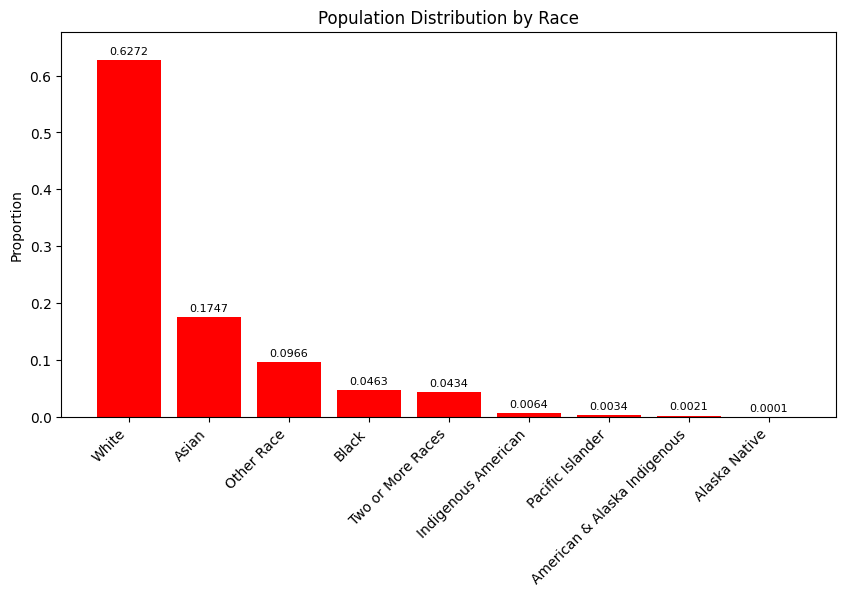

In [27]:
# Get population distribution
population_division = dict(data_original.RAC1P.value_counts(normalize=True))

# Mapping race codes to race names
race_mapping = {
    1: "White",
    2: "Black",
    3: "Indigenous American",
    4: "Alaska Native",
    5: "American & Alaska Indigenous",
    6: "Asian",
    7: "Pacific Islander",
    8: "Other Race",
    9: "Two or More Races"
}

# Extract race codes and population values
race_codes = list(population_division.keys())
population_values = list(population_division.values())

# Convert race codes to names
race_names = [race_mapping.get(code, f"Race {code}") for code in race_codes]

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(race_names, population_values, color="red")

# Labeling
plt.ylabel("Proportion")
plt.title("Population Distribution by Race")
plt.xticks(rotation=45, ha="right")

# Display values on bars
for i, value in enumerate(population_values):
    plt.text(i, value + 0.01, f"{value:.4f}", ha='center', fontsize=8)

plt.ylim(0, max(population_values) + 0.05)
plt.show()


 "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    }

In [30]:
print(f"percentage overall hit target: {for_analysis.target.value_counts(normalize=True)}\n")
print(f"percentage white people hit target : {data_original[data_original.RAC1P==1].target.value_counts(normalize=True)}\n")
print(f"percentage non-white people hit target :  {data_original[data_original.RAC1P!=1].target.value_counts(normalize=True)}\n")

percentage overall hit target: target
True     0.582243
False    0.417757
Name: proportion, dtype: float64

percentage white people hit target : target
True     0.609297
False    0.390703
Name: proportion, dtype: float64

percentage non-white people hit target :  target
True     0.536727
False    0.463273
Name: proportion, dtype: float64



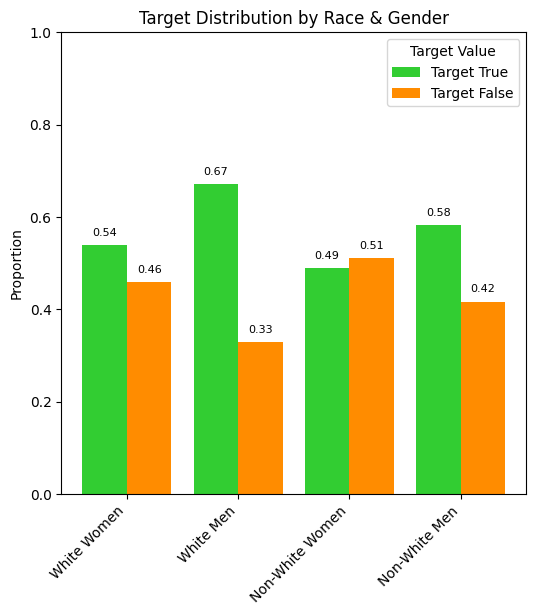

In [140]:
# Define masks for race
white_mask = (for_analysis.loc[:, "RAC1P_2":"RAC1P_9"] == 0).all(axis=1)
non_white_mask = (for_analysis.loc[:, "RAC1P_2":"RAC1P_9"] == 1).any(axis=1)

# Define masks for gender
woman_mask = for_analysis["SEX_2"] == 1
man_mask = for_analysis["SEX_2"] == 0

# Create combined groups
groups = {
    "White Women": for_analysis[white_mask & woman_mask],
    "White Men": for_analysis[white_mask & man_mask],
    "Non-White Women": for_analysis[non_white_mask & woman_mask],
    "Non-White Men": for_analysis[non_white_mask & man_mask]
}

# Collect data for plotting
group_names = []
target_distributions = []
for group_name, group_df in groups.items():
    target_dist = group_df["target"].value_counts(normalize=True).sort_index()
    group_names.append(group_name)
    target_distributions.append(target_dist)

target_colors = {True: "limegreen", False: "darkorange"}

# Convert list to numpy array for plotting
target_categories = sorted(for_analysis["target"].unique(), reverse=True)  # Reversed order
  # Ensure correct order of target values
num_targets = len(target_categories)
num_groups = len(groups)
bar_width = 0.4  # Width of bars

# Create bar positions
x = np.arange(num_groups)

# Plot results
plt.figure(figsize=(6, 6))

for i, target_val in enumerate(target_categories):
    values = [dist.get(target_val, 0) for dist in target_distributions]  # Get proportions for each group
    plt.bar(x + i * bar_width, values, bar_width, label=f"Target {target_val}", color=target_colors[target_val])

# Labeling
plt.xticks(x + (num_targets - 1) * bar_width / 2, group_names, rotation=45, ha="right")
plt.ylabel("Proportion")
plt.title("Target Distribution by Race & Gender")
plt.legend(title="Target Value")
plt.ylim(0, 1)

# Display values on bars
for i, target_val in enumerate(target_categories):
    values = [dist.get(target_val, 0) for dist in target_distributions]
    for j, value in enumerate(values):
        plt.text(x[j] + i * bar_width, value + 0.02, f"{value:.2f}", ha="center", fontsize=8)

plt.show()


# Task 1

Train one logistic regression model without any fairness constraing on the Folktales dataset and calculate its general accuracy, and respectively the accuracies for men and women (feature SEX) and for different races (feature RAC1P). Remember to evaluate the model using cross validation.

In [33]:
kf = KFold(n_splits=5)

logistic_model = LogisticRegression(max_iter=5000, penalty="l2", C=0.8497534359086438, tol=1e-4, solver="saga")
logistic_model.fit(X_train_small, y_train_small)

LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

In [40]:
log_y_pred = logistic_model.predict(X_test_small)
accuracy = accuracy_score(y_test_small, log_y_pred)
f1 = f1_score(y_test_small, log_y_pred) 
balanced_accuracy = balanced_accuracy_score(y_test_small, log_y_pred)

print(f"accuracy: {accuracy}")
print(f"f1-score: {f1}")
print(f"balanced accuracy: {balanced_accuracy}")

accuracy: 0.7362
f1-score: 0.7714830214830215
balanced accuracy: 0.7324511504512965


In [41]:

# evaluate model
scores = cross_val_score(
    logistic_model, X_train_small, y_train_small, scoring='accuracy', cv=kf, n_jobs=-1)

print('Accuracy: %.3f ,\nStandard Deviations :%.3f' %
      (mean(scores), std(scores)))

Accuracy: 0.807 ,
Standard Deviations :0.075


In [43]:

# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_women = (X_test_small['SEX_2'] == 1)  # Change to 0 for the other gender # Women
y_true_gender_women = y_test_small[gender_mask_women]
y_pred_gender_women = log_y_pred[gender_mask_women]
# Step 3: Compute accuracy for the selected gender
accuracy_women = accuracy_score(y_true_gender_women, y_pred_gender_women)
f1_score_women = f1_score(y_true_gender_women, y_pred_gender_women) 
balanced_accuracy_women = balanced_accuracy_score(y_true_gender_women, y_pred_gender_women)

print(f"Accuracy for gender sex_2 = 1 --> Women: {accuracy_women:.4f}, f1-score: {f1_score_women:.4f} and balanced accuracy: {balanced_accuracy_women:.4f}")

# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_men = (X_test_small['SEX_2'] == 0)  # Change to 0 for the other gender # Women
y_true_gender_men = y_test_small[gender_mask_men]
y_pred_gender_men = log_y_pred[gender_mask_men]

# Step 3: Compute accuracy for the selected gender
accuracy_men = accuracy_score(y_true_gender_men, y_pred_gender_men)
f1_score_men = f1_score(y_true_gender_men, y_pred_gender_men) 
balanced_accuracy_men = balanced_accuracy_score(y_true_gender_men, y_pred_gender_men)

print(f"Accuracy for gender sex_2 = 0 --> Men: {accuracy_men:.4f}, f1-score: {f1_score_men:.4f} and balanced accuracy: {balanced_accuracy_men:.4f}")


Accuracy for gender sex_2 = 1 --> Women: 0.7012, f1-score: 0.7117 and balanced accuracy: 0.7017
Accuracy for gender sex_2 = 0 --> Men: 0.7685, f1-score: 0.8167 and balanced accuracy: 0.7564


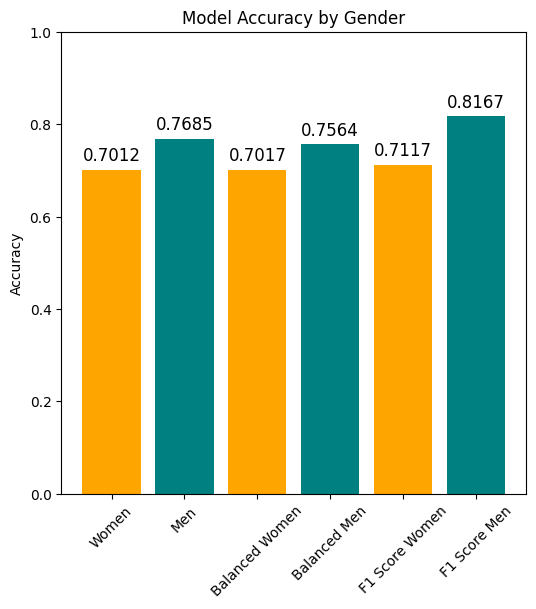

In [47]:
# Accuracy values
genders = ["Women", "Men", "Balanced Women", "Balanced Men", "F1 Score Women", "F1 Score Men"]
accuracies = [accuracy_women, accuracy_men, balanced_accuracy_women, balanced_accuracy_men, f1_score_women, f1_score_men]

# Plot the accuracies
plt.figure(figsize=(6, 6))
plt.bar(genders, accuracies, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Gender")
plt.xticks(rotation=45)

# Display values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

In [58]:
# Step 2: Identify race columns
race_columns = [col for col in X_test_small.columns if col.startswith("RAC1P_")]

race_accuracies = {}
race_balanced_accuracies = {}
race_f1_scores = {}

# calculate accuracy for each race group, plus all them being 0 = white
race1_mask = (X_test_small[race_columns].sum(axis=1) == 0)  # Rows where all race columns are 0
if race1_mask.sum() > 0:  # Check if there are any such samples
    y_true_white = y_test_small[race1_mask]
    y_pred_white = log_y_pred[race1_mask]
    accuracy_white = accuracy_score(y_true_white, y_pred_white)
    f1_score_white = f1_score(y_true_white, y_pred_white) 
    balanced_accuracy_white = balanced_accuracy_score(y_true_white, y_pred_white)
    race_accuracies["RAC1P_1"] = accuracy_white
    race_f1_scores["RAC1P_1"] = f1_score_white
    race_balanced_accuracies["RAC1P_1"] = balanced_accuracy_white

for race_col in race_columns:
    race_mask = (X_test_small[race_col] == 1)  # Select people belonging to this race
    if race_mask.sum() > 0:  # Avoid division by zero
        y_true_race = y_test_small[race_mask]
        y_pred_race = log_y_pred[race_mask]
        accuracy_non_white = accuracy_score(y_true_race, y_pred_race)
        f1_score_non_white = f1_score(y_true_race, y_pred_race) 
        balanced_accuracy_non_white = balanced_accuracy_score(y_true_race, y_pred_race)
        race_accuracies[race_col] = accuracy_non_white
        race_f1_scores[race_col] = f1_score_non_white
        race_balanced_accuracies[race_col] = balanced_accuracy_non_white



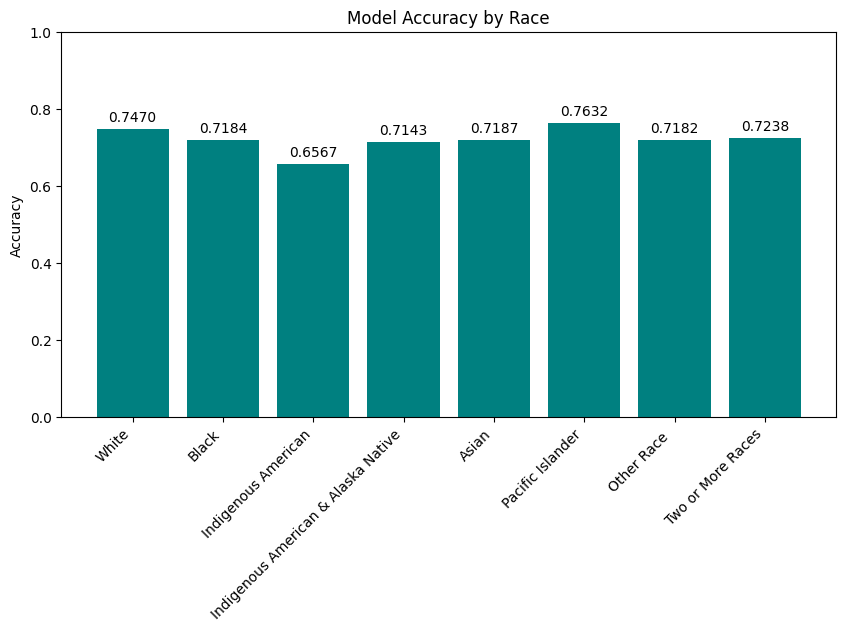

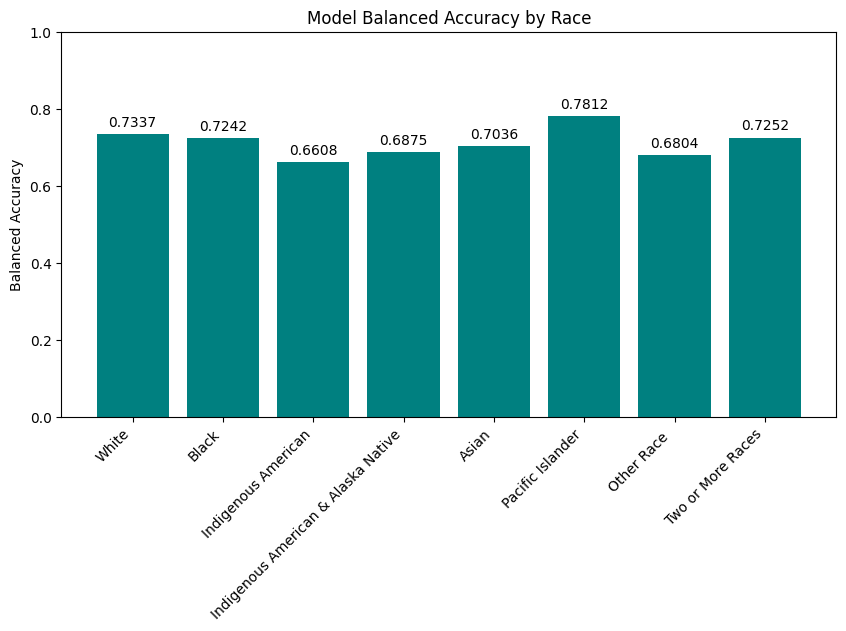

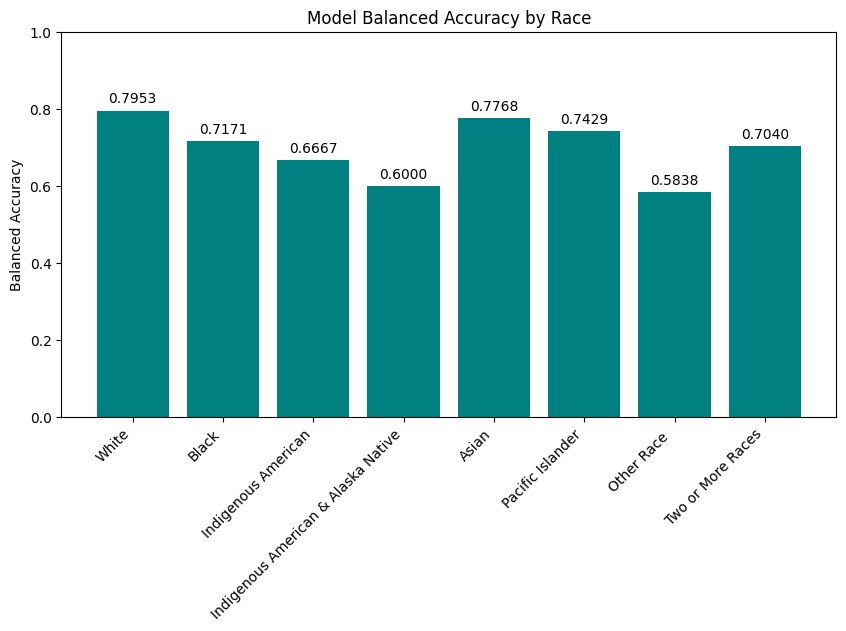

In [ ]:
# Mapping from RAC1P_# to race names
race_mapping = {
    1: "White",
    2: "Black",
    3: "Indigenous American",
    4: "Alaska Native",
    5: "Indigenous American & Alaska Native",
    6: "Asian",
    7: "Pacific Islander",
    8: "Other Race ",
    9: "Two or More Races"
}

# Extract numeric values from column names (RAC1P_# → #)
race_codes = [int(col.split('_')[1]) for col in race_accuracies.keys()]

# Map numeric values to race names
race_names = [race_mapping.get(code, f"Race {code}") for code in race_codes]
race_accuracies_values = list(race_accuracies.values())
race_balanced_accuracies_values = list(race_balanced_accuracies.values())
race_f1_scores_values = list(race_f1_scores.values())

# Plot the race-based accuracy results
plt.figure(figsize=(10, 5))
plt.bar(race_names, race_accuracies_values, color='teal')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Race")

# Adjust x-axis labels
plt.xticks(rotation=45, ha="right")

# Display values on bars
for i, acc in enumerate(race_accuracies_values):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()

# Plot the race-based accuracy results
plt.figure(figsize=(10, 5))
plt.bar(race_names, race_balanced_accuracies_values, color='teal')
plt.ylim(0, 1)
plt.ylabel("Balanced Accuracy")
plt.title("Model Balanced Accuracy by Race")
plt.xticks(rotation=45, ha="right")


# Display values on bars
for i, acc in enumerate(race_balanced_accuracies_values):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=10)

# Plot the race-based f1-score results
plt.figure(figsize=(10, 5))
plt.bar(race_names, race_f1_scores_values, color='teal')
plt.ylim(0, 1)
plt.ylabel("Balanced Accuracy")
plt.title("Model Balanced Accuracy by Race")
plt.xticks(rotation=45, ha="right")


# Display values on bars
for i, acc in enumerate(race_f1_scores_values):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=10)


plt.show()


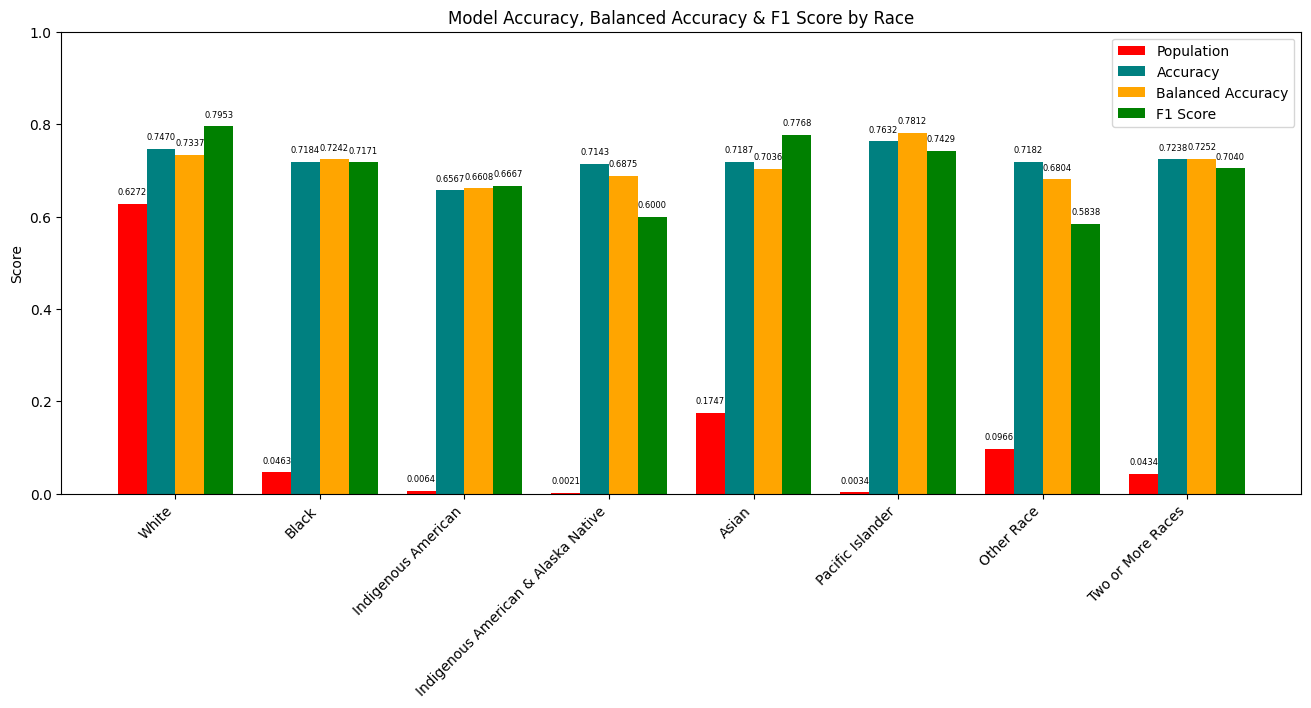

In [82]:
population_values = [pop_sorted[code] for code in race_codes if code in pop_sorted]

# Set positions for bars
x = np.arange(len(race_names))  # The label locations
width = 0.2  # Reduced bar width for better separation

# Create the bar plot
plt.figure(figsize=(16, 6))
bars0 = plt.bar(x - 1.5 * width, population_values, width, label="Population", color="red")
bars1 = plt.bar(x - 0.5 * width, race_accuracies_values, width, label="Accuracy", color='teal')
bars2 = plt.bar(x + 0.5 * width, race_balanced_accuracies_values, width, label="Balanced Accuracy", color='orange')
bars3 = plt.bar(x + 1.5 * width, race_f1_scores_values, width, label="F1 Score", color='green')

# Labeling
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Accuracy, Balanced Accuracy & F1 Score by Race")
plt.xticks(x, race_names, rotation=45, ha="right")
plt.legend()

# Display values on bars
for bars in [bars0, bars1, bars2, bars3]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f"{bar.get_height():.4f}", ha='center', fontsize=6)

plt.show()


# task 2- gender division


In [101]:
def sigmoid(x):
    """
    Compute the sigmoid function 
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1./(1 + np.exp(-x.astype(float)))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_pred are probabilities
    """
    return -np.mean(y_true * np.log(y_pred + eps) + (1-y_true) * np.log(1-y_pred + eps))

def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta,2)

def fair_loss_group(y, probs, groups, group_type):
    """
    Individual fairness Loss for gender
    """
    if group_type == "gender":
        n = y.shape[0]
        n1 = np.sum(groups == 1)
        n2 = np.sum(groups == 2)
    elif group_type == "race":
        n = y.shape[0]
        n1 = np.sum(groups == 0)
        n2 = np.sum(groups == 1)
    #print(n, n1, n2)
    
    ## Solution with numpy
    equal_pairs = np.argwhere(y[np.newaxis, :] == y[:, np.newaxis]) ### Check if labels are the same, distance is 1 if y[i] == y[j] and 0 if y[i] != y[j]
    equal_pairs = equal_pairs[np.where(equal_pairs[:,0] != equal_pairs[:,1])] ### Remove the pairs where items are compared to themselves
    
    
    diff_groups = (groups[equal_pairs[:,0]] != groups[equal_pairs[:,1]]).astype(int) ### Find pairs where groups are different
    
    diff_probs = probs[equal_pairs[:,0]].to_numpy() - probs[equal_pairs[:,1]].to_numpy()
   
    
    cost = diff_groups.dot(diff_probs)  # Ensures correct dot product shape
    cost /= (n1*n2)
    
    return cost**2

def compute_cost(beta, X, y, groups, group_type, _lambda, _gamma):
    # Compute predicted probs
    probs = sigmoid(X.dot(beta).astype(float))
    # Compute joint loss
    loss = logistic_loss(y, probs) + _lambda * fair_loss_group(y, probs, groups, group_type) + _gamma * l2_loss(beta[1:])
    return loss

def compute_gradients(beta, X, y, groups, group_type, _lambda, _gamma):
    """
    Calculate the gradient - used for finding the best beta values
    """
    # Start with empty gradient
    grad = np.zeros(beta.shape)
    
    m = len(X) # Number of training samples
    
    # Calculate the probs
    probs = sigmoid(X.dot(beta).astype(float))
    
    # Calculate gradients for each beta value
    for j in range(len(grad)):
        if j == 0: ### We do not want to regularize the intercept
            grad[j] = (1/m) * (probs-y).dot(X.iloc[:,j])
        else:
            grad[j] = (1/m) * (probs-y).dot(X.iloc[:,j]) + (2*_gamma)*beta[j]
        
    return grad

In [ ]:
print("checking whether sex and race ratio is the same in the sample as in the overall data")
print(X_train_small.SEX_2.value_counts(normalize=True))
print(X_train_small.race.value_counts(normalize=True))

checking whether sex and race ratio is the same in the sample as in the overall data
SEX_2
False    0.552
True     0.448
Name: proportion, dtype: float64
race
1    0.6031
0    0.3969
Name: proportion, dtype: float64


In [ ]:
# Compute cost with random beta-values and parameters
compute_cost(
    beta = np.random.rand(X_train_small.shape[1]),
    X = X_train_small, 
    y = y_train_small,
    groups = group_g_train_small, 
    group_type = "gender",
    _gamma = 1, 
    _lambda = 0.1
)

np.float64(5.609082246458783)

In [115]:
# Set seed and define params
beta = np.random.rand(X_train_small.shape[1])
lambda_ = 0.1
gamma_ = 1e-5 

# Run optimization
result_g, _, _ = opt.fmin_tnc(
    func=compute_cost,
    x0=beta,
    fprime=compute_gradients,
    approx_grad=False,
    maxfun = 500,
    args = (
        X_train_small, 
        y_train_small,
        group_g_train_small,
        "gender",
        lambda_, 
        gamma_
    ),
    xtol=1e-7,
    ftol=1e-5
)

KeyboardInterrupt: 

In [34]:
# Save result
np.save("optimized_beta_g_10000.npy", result_g)

In [36]:

# Load result next time
result_g = np.load("optimised_models/optimized_beta_g_10000.npy")
result_g

array([-1.01922636,  0.09545431,  0.73513217, -1.1930673 ,  0.26187311,
        0.30767571, -0.35645016, -0.22652388, -0.00647795, -0.07211205,
       -0.08673966, -0.34049988,  0.30594286, -1.91066872, -0.17653376,
       -0.05161975, -0.27369262, -0.05727317,  0.49280514,  1.17240259,
        1.57681339,  1.86744173,  2.16397903, -0.73831252, -0.25150039,
       -0.77796307, -1.14107596, -0.60757446, -0.33563763,  0.19492561,
       -0.05878131, -1.71036319, -0.24045473,  0.30357618, -0.16543926,
       -0.30043927, -0.14776919, -0.57103011, -0.76532084,  0.06364744,
        0.66204789, -0.06132924])

In [ ]:
y_pred_fair_g = np.array([True if x >=0.5 else False for x in sigmoid(result_g @ X_test_small.T)])

0.7365

### plotting results

In [121]:
fair_women = accuracy_score(y_test_small[group_g_test_small==2], y_pred_fair_g[group_g_test_small==2])
fair_men = accuracy_score(y_test_small[group_g_test_small==1], y_pred_fair_g[group_g_test_small==1])

basic_women = accuracy_score(y_test_small[group_g_test_small==2], log_y_pred[group_g_test_small==2])
basic_men = accuracy_score(y_test_small[group_g_test_small==1], log_y_pred[group_g_test_small==1])

balanced_fair_women = balanced_accuracy_score(y_test_small[group_g_test_small==2], y_pred_fair_g[group_g_test_small==2])
balanced_fair_men = balanced_accuracy_score(y_test_small[group_g_test_small==1], y_pred_fair_g[group_g_test_small==1])

balanced_basic_women = balanced_accuracy_score(y_test_small[group_g_test_small==2], log_y_pred[group_g_test_small==2])
balanced_basic_men = balanced_accuracy_score(y_test_small[group_g_test_small==1], log_y_pred[group_g_test_small==1])

f1_score_fair_women =  f1_score(y_test_small[group_g_test_small==2], y_pred_fair_g[group_g_test_small==2])
f1_score_fair_men  = f1_score(y_test_small[group_g_test_small==1], y_pred_fair_g[group_g_test_small==1])

f1_score_basic_women =  f1_score(y_test_small[group_g_test_small==2], log_y_pred[group_g_test_small==2])
f1_score_basic_men  = f1_score(y_test_small[group_g_test_small==1], log_y_pred[group_g_test_small==1])


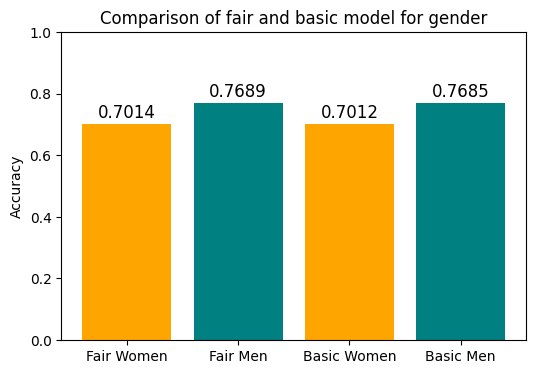

In [122]:

# Accuracy values
genders = ["Fair Women\n", "Fair Men\n", "Basic Women\n", "Basic Men\n"]
accuracies_g = [fair_women, fair_men, basic_women, basic_men]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(genders, accuracies_g, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for gender")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(accuracies_g):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

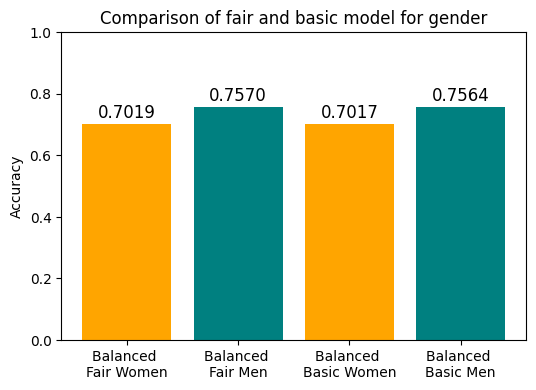

In [123]:

# Accuracy values
balanced_genders = ["Balanced \nFair Women", "Balanced \nFair Men", "Balanced \nBasic Women", "Balanced \nBasic Men"]
balanced_accuracies_g = [balanced_fair_women, balanced_fair_men, balanced_basic_women, balanced_basic_men]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(balanced_genders, balanced_accuracies_g, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for gender")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(balanced_accuracies_g):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

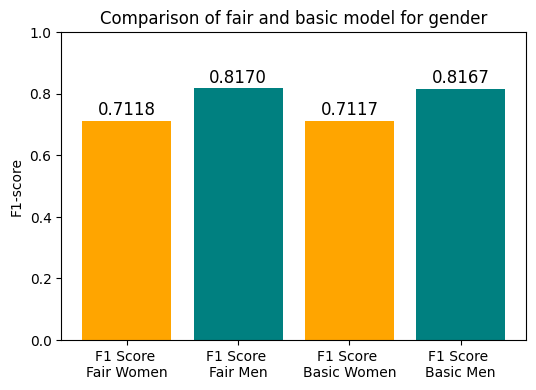

In [124]:

# Accuracy values
f1_genders = ["F1 Score \nFair Women", "F1 Score \nFair Men", "F1 Score \nBasic Women", "F1 Score \nBasic Men"]
f1_g = [f1_score_fair_women, f1_score_fair_men, f1_score_basic_women, f1_score_basic_men]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(f1_genders, f1_g, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("Comparison of fair and basic model for gender")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(f1_g):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

# Task 2 for race division

In [ ]:
# Compute cost with random beta-values and parameters
compute_cost(
    beta = np.random.rand(X_train_small.shape[1]),
    X = X_train_small, 
    y = y_train_small,
    groups = group_r_train_small, 
    group_type = "race",
    _gamma = 1, 
    _lambda = 0.1
)

np.float64(5.375583183483104)

In [117]:
# Set seed and define params
beta = np.random.rand(X_train_small.shape[1])
lambda_ = 0.1
gamma_ = 1e-5 

# Run optimization
result_r, _, _ = opt.fmin_tnc(
    func=compute_cost,
    x0=beta,
    fprime=compute_gradients,
    approx_grad=False,
    maxfun = 500,
    args = (
        X_train_small, 
        y_train_small,
        group_r_train_small,
        "race",
        lambda_, 
        gamma_
    ),
    xtol=1e-7,
    ftol=1e-5
)

  NIT   NF   F                       GTG
    0    1  1.694566831429358E+00   1.23750708E+00
    1    6  6.173211254507118E-01   1.62279859E-01
    2    9  4.467809685648232E-01   2.15748176E-03
    3   16  4.236172018788110E-01   1.17363740E-04
tnc: fscale = 53.4814
    4   24  4.195466718365453E-01   4.99344423E-06
    5   32  4.183876517966368E-01   7.27848249E-07
    6   35  4.183222408529133E-01   1.29268163E-06
    7   42  4.182013973837356E-01   1.32263706E-07
tnc: fscale = 1639.83
    8   55  4.181799408206620E-01   3.81962016E-08
    9   60  4.181669080869849E-01   2.49180843E-08
tnc: |fn-fn-1] = 6.39341e-06 -> convergence
   10   68  4.181605146806742E-01   8.91142851E-09
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [126]:
# Save result
np.save("optimized_beta_r_10000.npy", result_r)

In [127]:
# Load result next time
result_r = np.load("optimised_models/optimized_beta_r_10000.npy")

In [128]:
y_pred_fair_r = np.array([True if x >=0.5 else False for x in sigmoid(result_r @ X_test_small.T)])

In [131]:
fair_white = accuracy_score(y_test_small[group_r_test_small==1], y_pred_fair_r[group_r_test_small==1])
fair_non_white = accuracy_score(y_test_small[group_r_test_small==0], y_pred_fair_r[group_r_test_small==0])

basic_white = accuracy_score(y_test_small[group_r_test_small==1], log_y_pred[group_r_test_small==1])
basic_non_white = accuracy_score(y_test_small[group_r_test_small==0], log_y_pred[group_r_test_small==0])

balanced_fair_white = balanced_accuracy_score(y_test_small[group_r_test_small==1], y_pred_fair_r[group_r_test_small==1])
balanced_fair_non_white = balanced_accuracy_score(y_test_small[group_r_test_small==0], y_pred_fair_r[group_r_test_small==0])

balanced_basic_white = balanced_accuracy_score(y_test_small[group_r_test_small==1], log_y_pred[group_r_test_small==1])
balanced_basic_non_white = balanced_accuracy_score(y_test_small[group_r_test_small==0], log_y_pred[group_r_test_small==0])

f1_score_fair_white =  f1_score(y_test_small[group_r_test_small==1], y_pred_fair_r[group_r_test_small==1])
f1_score_fair_non_white  = f1_score(y_test_small[group_r_test_small==0], y_pred_fair_r[group_r_test_small==0])

f1_score_basic_white =  f1_score(y_test_small[group_r_test_small==1], log_y_pred[group_r_test_small==1])
f1_score_basic_non_white  = f1_score(y_test_small[group_r_test_small==0], log_y_pred[group_r_test_small==0])


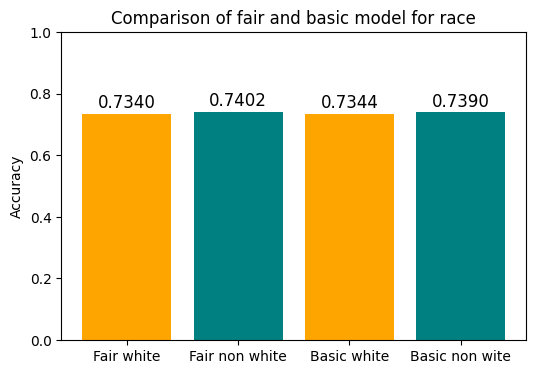

In [132]:

# Accuracy values
races = ["Fair white\n", "Fair non white\n", "Basic white\n", "Basic non wite\n"]
accuracies_r = [fair_white, fair_non_white, basic_white, basic_non_white]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(races, accuracies_r, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for race")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(accuracies_r):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

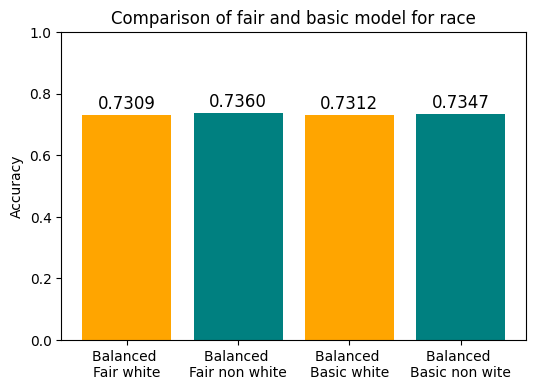

In [133]:

# Accuracy values
balanced_races = ["Balanced \nFair white", "Balanced \nFair non white", "Balanced \nBasic white", "Balanced \nBasic non wite"]
balanced_accuracies_r = [balanced_fair_white, balanced_fair_non_white, balanced_basic_white, balanced_basic_non_white]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(balanced_races, balanced_accuracies_r, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for race")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(balanced_accuracies_r):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

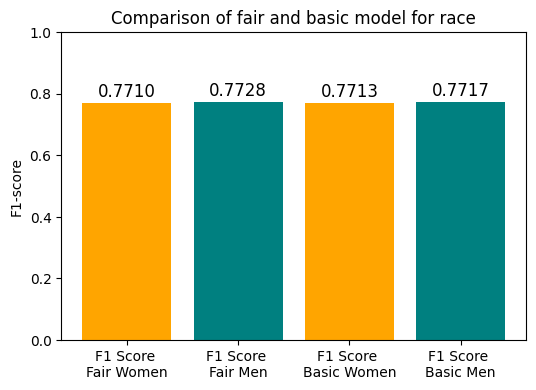

In [135]:
# Accuracy values
f1_race = ["F1 Score \nFair Women", "F1 Score \nFair Men", "F1 Score \nBasic Women", "F1 Score \nBasic Men"]
f1_r = [f1_score_fair_white, f1_score_fair_non_white, f1_score_basic_white, f1_score_basic_non_white]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(f1_race, f1_r, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("Comparison of fair and basic model for race")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(f1_r):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()